In [1]:
from pathlib import Path
import time
import datetime
from tqdm import tqdm
from collections import defaultdict, Counter
import copy
import random
import re
import numpy as np
import os
from sklearn.metrics import roc_auc_score
import pickle

In [2]:
os.environ['CUDA_VISIBLE_DEVICES'] = "1"

In [3]:
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn
import torch.optim as optim
import torch.nn.functional as F

In [4]:
device = torch.device("cuda:0")

In [5]:
torch.cuda.set_device(device)

In [6]:
# data_path = Path("/home/v-jingweiyi/data/FL/data/adressa")
data_path = Path("/data4/u6015325/data/adressa/utils")

In [7]:
npratio = 4
max_his_len = 50
min_word_cnt = 3
max_title_len = 30

In [8]:
batch_size = 64
epoch = 10
lr=0.0001
name = 'nrms-adressa'

# collect impressions

In [9]:
with open(data_path/'train_contexts.pkl', 'rb') as f:
    train_sam = pickle.load(f)
    
with open(data_path/'valid_contexts.pkl', 'rb') as f:
    valid_sam = pickle.load(f)
    
with open(data_path/'test_contexts.pkl', 'rb') as f:
    test_sam = pickle.load(f)

In [10]:
len(train_sam)

233275

# News Preprocesss

In [11]:
with open(data_path/'nid2index.pkl', 'rb') as f:
    nid2index = pickle.load(f)
    
with open(data_path/'vocab_dict.pkl', 'rb') as f:
    vocab_dict = pickle.load(f)

embedding_matrix = np.load(data_path/'embedding.npy')
news_index = np.load(data_path /'news_index.npy')

# Dataset & DataLoader

In [12]:
def newsample(nnn, ratio):
    if ratio > len(nnn):
        return nnn + ["<unk>"] * (ratio - len(nnn))
    else:
        return random.sample(nnn, ratio)

In [13]:
class TrainDataset(Dataset):
    def __init__(self, samples, nid2index, news_index):
        self.news_index = news_index
        self.nid2index = nid2index
        self.samples = samples
        
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        # pos, neg, his, neg_his
        pos, neg, his, _, _ = self.samples[idx]
        neg = newsample(neg, npratio)
        candidate_news = [pos] + neg
        candidate_news = self.news_index[[self.nid2index[n] for n in candidate_news]]
        his = [self.nid2index[n] for n in his] + [0] * (max_his_len - len(his))
        his = self.news_index[his]
        
        label = np.array(0)
        return candidate_news, his, label

In [14]:
class NewsDataset(Dataset):
    def __init__(self, news_index):
        self.news_index = news_index
        
    def __len__(self):
        return len(self.news_index)
    
    def __getitem__(self, idx):
        return self.news_index[idx]

In [15]:
news_dataset = NewsDataset(news_index)

In [16]:
class UserDataset(Dataset):
    def __init__(self, 
                 samples,
                 news_vecs,
                 nid2index):
        self.samples = samples
        self.news_vecs = news_vecs
        self.nid2index = nid2index
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        poss, negs, his, _, _ = self.samples[idx]
        his = [self.nid2index[n] for n in his] + [0] * (max_his_len - len(his))
        his = self.news_vecs[his]
        return his

# Model

In [17]:
class ScaledDotProductAttention(nn.Module):
    def __init__(self, d_k):
        super(ScaledDotProductAttention, self).__init__()
        self.d_k = d_k

    def forward(self, Q, K, V, attn_mask=None):
        scores = torch.matmul(Q, K.transpose(-1, -2)) / np.sqrt(self.d_k)
        scores = torch.exp(scores)
        if attn_mask is not None:
            scores = scores * attn_mask
        attn = scores / (torch.sum(scores, dim=-1, keepdim=True)  + 1e-8)
        
        context = torch.matmul(attn, V)
        return context, attn

class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, n_heads, d_k, d_v):
        super(MultiHeadAttention, self).__init__()
        self.d_model = d_model # 300
        self.n_heads = n_heads # 20
        self.d_k = d_k # 20
        self.d_v = d_v # 20
        
        self.W_Q = nn.Linear(d_model, d_k * n_heads) # 300, 400
        self.W_K = nn.Linear(d_model, d_k * n_heads) # 300, 400
        self.W_V = nn.Linear(d_model, d_v * n_heads) # 300, 400
        
        self._initialize_weights()
                
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight, gain=1)
                
    def forward(self, Q, K, V, attn_mask=None):
        residual, batch_size = Q, Q.size(0)
        
        q_s = self.W_Q(Q).view(batch_size, -1, self.n_heads, self.d_k).transpose(1,2)
        k_s = self.W_K(K).view(batch_size, -1, self.n_heads, self.d_k).transpose(1,2)
        v_s = self.W_V(V).view(batch_size, -1, self.n_heads, self.d_v).transpose(1,2)
        
        if attn_mask is not None:
            attn_mask = attn_mask.unsqueeze(1).expand(batch_size, max_len, max_len) 
            attn_mask = attn_mask.unsqueeze(1).repeat(1, self.n_heads, 1, 1) 
        
        context, attn = ScaledDotProductAttention(self.d_k)(q_s, k_s, v_s, attn_mask) 
        context = context.transpose(1, 2).contiguous().view(batch_size, -1, self.n_heads * self.d_v) 
        return context 

In [18]:

class AdditiveAttention(nn.Module):
    ''' AttentionPooling used to weighted aggregate news vectors
    Arg: 
        d_h: the last dimension of input
    '''
    def __init__(self, d_h, hidden_size=200):
        super(AdditiveAttention, self).__init__()
        self.att_fc1 = nn.Linear(d_h, hidden_size)
        self.att_fc2 = nn.Linear(hidden_size, 1)

    def forward(self, x, attn_mask=None):
        """
        Args:
            x: batch_size, candidate_size, candidate_vector_dim
            attn_mask: batch_size, candidate_size
        Returns:
            (shape) batch_size, candidate_vector_dim
        """
        bz = x.shape[0]
        e = self.att_fc1(x)
        e = nn.Tanh()(e)
        alpha = self.att_fc2(e)

        alpha = torch.exp(alpha)
        if attn_mask is not None:
            alpha = alpha * attn_mask.unsqueeze(2)
        alpha = alpha / (torch.sum(alpha, dim=1, keepdim=True) + 1e-8)

        x = torch.bmm(x.permute(0, 2, 1), alpha)
        x = torch.reshape(x, (bz, -1))  # (bz, 400)
        return x

In [19]:
class TextEncoder(nn.Module):
    def __init__(self, 
                 word_embedding_dim=300, 
                 num_attention_heads=20,
                 query_vector_dim = 200,
                 dropout_rate=0.2,
                 enable_gpu=True):
        super(TextEncoder, self).__init__()
        self.dropout_rate = 0.2
        pretrained_news_word_embedding = torch.from_numpy(embedding_matrix).float()
        
        self.word_embedding = nn.Embedding.from_pretrained(
            pretrained_news_word_embedding, freeze=True)
        
        self.multihead_attention = MultiHeadAttention(word_embedding_dim,
                                              num_attention_heads, 20, 20)
        self.additive_attention = AdditiveAttention(num_attention_heads*20,
                                                    query_vector_dim)
    def forward(self, text):
        text_vector = F.dropout(self.word_embedding(text.long()),
                                p=self.dropout_rate,
                                training=self.training)
        multihead_text_vector = self.multihead_attention(
            text_vector, text_vector, text_vector)
        multihead_text_vector = F.dropout(multihead_text_vector,
                                          p=self.dropout_rate,
                                          training=self.training)
        # batch_size, word_embedding_dim
        text_vector = self.additive_attention(multihead_text_vector)
        return text_vector

In [20]:
class UserEncoder(nn.Module):
    def __init__(self,
                 news_embedding_dim=400,
                 num_attention_heads=20,
                 query_vector_dim=200
                ):
        super(UserEncoder, self).__init__()
        self.multihead_attention = MultiHeadAttention(news_embedding_dim,
                                              num_attention_heads, 20, 20)
        self.additive_attention = AdditiveAttention(num_attention_heads*20,
                                                    query_vector_dim)
        
        self.neg_multihead_attention = MultiHeadAttention(news_embedding_dim,
                                                         num_attention_heads, 20, 20)
        self.dropout_rate = 0.2
        
    def forward(self, clicked_news_vecs):
        multi_clicked_vectors =self.multihead_attention(
            clicked_news_vecs, clicked_news_vecs, clicked_news_vecs
        )
        pos_user_vector = self.additive_attention(multi_clicked_vectors)
        user_vector = pos_user_vector
        return user_vector

In [21]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.text_encoder = TextEncoder()
        self.user_encoder = UserEncoder()
        
        self.criterion = nn.CrossEntropyLoss()
    
    def forward(self, candidate_news, clicked_news, targets, compute_loss=True):
        batch_size, npratio, word_num = candidate_news.shape
        candidate_news = candidate_news.view(-1, word_num)
        candidate_vector = self.text_encoder(candidate_news).view(batch_size, npratio, -1)
        
        batch_size, clicked_news_num, word_num = clicked_news.shape
        clicked_news = clicked_news.view(-1, word_num)
        clicked_news_vecs = self.text_encoder(clicked_news).view(batch_size, clicked_news_num, -1)
        
        user_vector = self.user_encoder(clicked_news_vecs)
        
        score = torch.bmm(candidate_vector, user_vector.unsqueeze(-1)).squeeze(dim=-1)
        
        if compute_loss:
            loss = self.criterion(score, targets)
            return loss, score
        else:
            return score

# Train

In [22]:
def dcg_score(y_true, y_score, k=10):
    order = np.argsort(y_score)[::-1]
    y_true = np.take(y_true, order[:k])
    gains = 2 ** y_true - 1
    discounts = np.log2(np.arange(len(y_true)) + 2)
    return np.sum(gains / discounts)


def ndcg_score(y_true, y_score, k=10):
    best = dcg_score(y_true, y_true, k)
    actual = dcg_score(y_true, y_score, k)
    return actual / best


def mrr_score(y_true, y_score):
    order = np.argsort(y_score)[::-1]
    y_true = np.take(y_true, order)
    rr_score = y_true / (np.arange(len(y_true)) + 1)
    return np.sum(rr_score) / np.sum(y_true)

In [23]:
def compute_amn(y_true, y_score):
    auc = roc_auc_score(y_true,y_score)
    mrr = mrr_score(y_true,y_score)
    ndcg5 = ndcg_score(y_true,y_score,5)
    ndcg10 = ndcg_score(y_true,y_score,10)
    return auc, mrr, ndcg5, ndcg10

def evaluation_split(news_vecs, user_vecs, samples, nid2index):
    all_rslt = []
    for i in tqdm(range(len(samples))):
        poss, negs, _, _, _ = samples[i]
        user_vec = user_vecs[i]
        y_true = [1] * len(poss) + [0] * len(negs)
        news_ids = [nid2index[i] for i in poss + negs]
        news_vec = news_vecs[news_ids]
        y_score = np.multiply(news_vec, user_vec)
        y_score = np.sum(y_score, axis=1)
        try:
            all_rslt.append(compute_amn(y_true, y_score))
        except Exception as e:
#             print(e)
            print(y_score)
    return np.array(all_rslt)

In [24]:
train_ds = TrainDataset(train_sam, nid2index, news_index)
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=0)

In [ ]:
import torch.autograd as autograd
for time in range(5):
    model = Model().to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    best_auc = 0
    for ep in range(1):
        loss = 0
        accuary = 0.0
        model.train()
        train_loader = tqdm(train_dl)
        for cnt, batch_sample in enumerate(train_loader):
            candidate_news_index, his_index, label = batch_sample
            sample_num = candidate_news_index.shape[0]
            candidate_news_index = candidate_news_index.to(device)
            his_index = his_index.to(device)
            label = label.to(device)
            bz_loss, y_hat = model(candidate_news_index, his_index, label)
           
            loss += bz_loss.detach().cpu().numpy()
            optimizer.zero_grad()
            with autograd.detect_anomaly():
                bz_loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)

            optimizer.step()

            if cnt % 10 == 0:
                train_loader.set_description(f"[{cnt}]steps loss: {loss / (cnt+1):.4f} ")
                train_loader.refresh() 


        model.eval()
        news_dl = DataLoader(news_dataset, batch_size=1024, shuffle=False, num_workers=0)
        news_vecs = []
        for news in tqdm(news_dl):
            news = news.to(device)
            news_vec = model.text_encoder(news).detach().cpu().numpy()
            news_vecs.append(news_vec)
        news_vecs = np.concatenate(news_vecs)

        user_dataset = UserDataset(valid_sam, news_vecs, nid2index)
        user_vecs = []
        user_dl = DataLoader(user_dataset, batch_size=1024, shuffle=False, num_workers=0)
        for his in tqdm(user_dl):
            his = his.to(device)
            user_vec = model.user_encoder(his).detach().cpu().numpy()
            user_vecs.append(user_vec)
        user_vecs = np.concatenate(user_vecs)

        val_scores = evaluation_split(news_vecs, user_vecs, valid_sam, nid2index)
        val_auc, val_mrr, val_ndcg, val_ndcg10 = [np.mean(i) for i in list(zip(*val_scores))]
        print(f"[{ep}] epoch auc: {val_auc:.4f}, mrr: {val_mrr:.4f}, ndcg5: {val_ndcg:.4f}, ndcg10: {val_ndcg10:.4f}")

        with open(f'./rslt/{name}.txt', 'a') as f:
              f.write(f"[{ep}] epoch auc: {val_auc:.4f}, mrr: {val_mrr:.4f}, ndcg5: {val_ndcg:.4f}, ndcg10: {val_ndcg10:.4f}\n")
                
        if val_auc > best_auc:
            best_auc = val_auc
            torch.save(model.state_dict(), f'./model/{name}.pkl')
            with open(f'./rslt/{name}.txt', 'a') as f:
                f.write(f"[{ep}] epoch save model\n")
            
    model.load_state_dict(torch.load(f'./model/{name}.pkl'))
    test_news_dataset = NewsDataset(news_index)
    news_dl = DataLoader(test_news_dataset, batch_size=1024, shuffle=False, num_workers=0)
    news_vecs = []
    for news in tqdm(news_dl):
        news = news.to(device)
        news_vec = model.text_encoder(news).detach().cpu().numpy()
        news_vecs.append(news_vec)
    news_vecs = np.concatenate(news_vecs)

    user_dataset = UserDataset(test_sam, news_vecs, nid2index)
    user_vecs = []
    user_dl = DataLoader(user_dataset, batch_size=1024, shuffle=False, num_workers=0)
    for his in tqdm(user_dl):
        his = his.to(device)
        user_vec = model.user_encoder(his).detach().cpu().numpy()
        user_vecs.append(user_vec)
    user_vecs = np.concatenate(user_vecs)

    test_scores = evaluation_split(news_vecs, user_vecs, test_sam, nid2index)
    test_auc, test_mrr, test_ndcg, test_ndcg10 = [np.mean(i) for i in list(zip(*test_scores))]
    print(f"[{time}] time test auc: {test_auc:.4f}, mrr: {test_mrr:.4f}, ndcg5: {test_ndcg:.4f}, ndcg10: {test_ndcg10:.4f}")

    with open(f'./rslt/{name}.txt', 'a') as f:
          f.write(f"[{time}] time test auc: {test_auc:.4f}, mrr: {test_mrr:.4f}, ndcg5: {test_ndcg:.4f}, ndcg10: {test_ndcg10:.4f}\n")
        

In [27]:
model = Model().to(device)
model.load_state_dict(torch.load(f'./pretrained_models/{name}.pkl'))
test_news_dataset = NewsDataset(news_index)
news_dl = DataLoader(test_news_dataset, batch_size=1024, shuffle=False, num_workers=0)
news_vecs = []
for news in tqdm(news_dl):
    news = news.to(device)
    news_vec = model.text_encoder(news).detach().cpu().numpy()
    news_vecs.append(news_vec)
news_vecs = np.concatenate(news_vecs)

user_dataset = UserDataset(test_sam, news_vecs, nid2index)
user_vecs = []
user_dl = DataLoader(user_dataset, batch_size=1024, shuffle=False, num_workers=0)
for his in tqdm(user_dl):
    his = his.to(device)
    user_vec = model.user_encoder(his).detach().cpu().numpy()
    user_vecs.append(user_vec)
user_vecs = np.concatenate(user_vecs)

test_scores = evaluation_split(news_vecs, user_vecs, test_sam, nid2index)
test_auc, test_mrr, test_ndcg, test_ndcg10 = [np.mean(i) for i in list(zip(*test_scores))]
print(f"[{time}] time test auc: {test_auc:.4f}, mrr: {test_mrr:.4f}, ndcg5: {test_ndcg:.4f}, ndcg10: {test_ndcg10:.4f}")

with open(f'./rslt/{name}.txt', 'a') as f:
      f.write(f"[{time}] time test auc: {test_auc:.4f}, mrr: {test_mrr:.4f}, ndcg5: {test_ndcg:.4f}, ndcg10: {test_ndcg10:.4f}\n")


100%|██████████| 181847/181847 [03:59<00:00, 758.96it/s]


[<module 'time' (built-in)>] time test auc: 0.7174, mrr: 0.4254, ndcg5: 0.4386, ndcg10: 0.4831


In [ ]:
from sklearn.metrics import roc_curve, precision_recall_curve

y_trues = []
y_scores = []
for i in tqdm(range(len(test_sam))):
    poss, negs, _, _, _ = test_sam[i]
    user_vec = user_vecs[i]
    y_true = [1] * len(poss) + [0] * len(negs)
    news_ids = [nid2index[i] for i in poss + negs]
    news_vec = news_vecs[news_ids]
    y_score = np.multiply(news_vec, user_vec)
    y_score = np.sum(y_score, axis=1)
        
    y_trues.append(y_true)
    y_scores.append(y_score)
    
y_trues = np.hstack(y_trues)
y_scores = np.hstack(y_scores)

(array([3636940.,       0.,       0.,       0.,       0.,       0.,
              0.,       0.,       0.,  181847.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

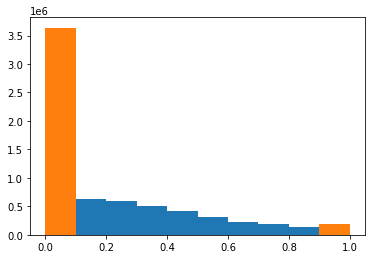

In [42]:
import matplotlib.pyplot as plt
import math

def sigmoid(x):
    return 1 / (1 + np.exp(-x)) 
plt.hist(sigmoid(y_scores))
# plt.hist(y_scores)
plt.hist(y_trues)

In [44]:
precision, recall, thresholds = precision_recall_curve(y_trues, sigmoid(y_scores))
fscore = (2 * precision * recall) / (precision + recall)
ix = np.argmax(fscore)
print(' Best Threshold=%f, fscore=%.3f' % (thresholds[ix], fscore[ix]))

 Best Threshold=0.999974, fscore=nan


<ipython-input-44-e5945f1bb43c>:2: RuntimeWarning: invalid value encountered in true_divide
  fscore = (2 * precision * recall) / (precision + recall)


In [ ]:
for time in range(9, 10):
    model = Model().to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    best_auc = 0
    for ep in range(1):
        loss = 0
        accuary = 0.0
        model.train()
        train_loader = tqdm(train_dl)
        for cnt, batch_sample in enumerate(train_loader):
            candidate_news_index, his_index, label = batch_sample
            sample_num = candidate_news_index.shape[0]
            candidate_news_index = candidate_news_index.to(device)
            his_index = his_index.to(device)
            label = label.to(device)
            bz_loss, y_hat = model(candidate_news_index, his_index, label)

            loss += bz_loss.detach().cpu().numpy()
            optimizer.zero_grad()
            bz_loss.backward()

            optimizer.step()

            if cnt % 10 == 0:
                train_loader.set_description(f"[{cnt}]steps loss: {loss / (cnt+1):.4f} ")
                train_loader.refresh() 


        model.eval()
        news_dl = DataLoader(news_dataset, batch_size=1024, shuffle=False, num_workers=0)
        news_vecs = []
        for news in tqdm(news_dl):
            news = news.to(device)
            news_vec = model.text_encoder(news).detach().cpu().numpy()
            news_vecs.append(news_vec)
        news_vecs = np.concatenate(news_vecs)

        user_dataset = UserDataset(valid_sam, news_vecs, nid2index)
        user_vecs = []
        user_dl = DataLoader(user_dataset, batch_size=1024, shuffle=False, num_workers=0)
        for his in tqdm(user_dl):
            his = his.to(device)
            user_vec = model.user_encoder(his).detach().cpu().numpy()
            user_vecs.append(user_vec)
        user_vecs = np.concatenate(user_vecs)

        val_scores = evaluation_split(news_vecs, user_vecs, valid_sam, nid2index)
        val_auc, val_mrr, val_ndcg, val_ndcg10 = [np.mean(i) for i in list(zip(*val_scores))]
        print(f"[{ep}] epoch auc: {val_auc:.4f}, mrr: {val_mrr:.4f}, ndcg5: {val_ndcg:.4f}, ndcg10: {val_ndcg10:.4f}")

        with open(f'./rslt/{name}.txt', 'a') as f:
              f.write(f"[{ep}] epoch auc: {val_auc:.4f}, mrr: {val_mrr:.4f}, ndcg5: {val_ndcg:.4f}, ndcg10: {val_ndcg10:.4f}\n")
                
        if val_auc > best_auc:
            best_auc = val_auc
            torch.save(model.state_dict(), f'./model/{name}.pkl')
            with open(f'./rslt/{name}.txt', 'a') as f:
                f.write(f"[{ep}] epoch save model\n")
            
    model.load_state_dict(torch.load(f'./model/{name}.pkl'))
    test_news_dataset = NewsDataset(news_index)
    news_dl = DataLoader(test_news_dataset, batch_size=1024, shuffle=False, num_workers=0)
    news_vecs = []
    for news in tqdm(news_dl):
        news = news.to(device)
        news_vec = model.text_encoder(news).detach().cpu().numpy()
        news_vecs.append(news_vec)
    news_vecs = np.concatenate(news_vecs)

    user_dataset = UserDataset(test_sam, news_vecs, nid2index)
    user_vecs = []
    user_dl = DataLoader(user_dataset, batch_size=1024, shuffle=False, num_workers=0)
    for his in tqdm(user_dl):
        his = his.to(device)
        user_vec = model.user_encoder(his).detach().cpu().numpy()
        user_vecs.append(user_vec)
    user_vecs = np.concatenate(user_vecs)

    test_scores = evaluation_split(news_vecs, user_vecs, test_sam, nid2index)
    test_auc, test_mrr, test_ndcg, test_ndcg10 = [np.mean(i) for i in list(zip(*test_scores))]
    print(f"[{time}] time test auc: {test_auc:.4f}, mrr: {test_mrr:.4f}, ndcg5: {test_ndcg:.4f}, ndcg10: {test_ndcg10:.4f}")

    with open(f'./rslt/{name}.txt', 'a') as f:
          f.write(f"[{time}] time test auc: {test_auc:.4f}, mrr: {test_mrr:.4f}, ndcg5: {test_ndcg:.4f}, ndcg10: {test_ndcg10:.4f}\n")
        